In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pylab import rcParams
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('fivethirtyeight') # For plot

In [2]:
df=pd.read_csv('italy_region.csv')
df.sort_index(inplace=True)
df.fillna(0)
#print("Shape:",df.shape)
#print(df.columns)

,date,region_code,region_name,lat,long,hospitalized_with_symptoms,intensive_care,total_hospitalized,home_confinement,cumulative_positive_cases,daily_positive_cases,recovered,death,cumulative_cases,total_tests,total_people_tested,region_spatial
0,2020-02-24,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5,0.0,Abruzzo
1,2020-02-24,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0.0,Basilicata
2,2020-02-24,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1,0.0,Trentino-Alto Adige
3,2020-02-24,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1,0.0,Calabria
4,2020-02-24,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10,0.0,Campania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,2020-05-15,9,Toscana,43.769231,11.255889,238,67,305,2863,3168,-220,5739,976,9883,197365,144237.0,Toscana
1718,2020-05-15,4,P.A. Trento,46.068935,11.121231,53,9,62,344,406,-99,3461,451,4318,63700,38273.0,Trentino-Alto Adige
1719,2020-05-15,10,Umbria,43.106758,12.388247,25,2,27,63,90,-2,1259,73,1422,53801,37660.0,Umbria
1720,2020-05-15,2,Valle d'Aosta,45.737503,7.320149,37,0,37,40,77,-3,953,142,1172,11413,8814.0,Valle d'Aosta


In [3]:
#Genero dataframe per regione con PIL più alto, densità più alta e i rispettivi valori più bassi
Mpil=df.copy()
#mpil=df.copy()
Mden=df.copy()
#mden=df.copy()
#la regione con PIL più basso e densità più bassa è la stessa e quindi genero mtot per non generare 2 volte lo stesso dataframe
mtot=df.copy()

In [4]:
Mpil = Mpil[Mpil['region_code'] ==3]#lombardia
Mden = Mden[Mden['region_code'] ==15]#campania
mtot = mtot[mtot['region_code']==2]#valle

In [5]:
#resetto index dei dataframes
Mpil.reset_index(drop=True, inplace=True)
Mden.reset_index(drop=True, inplace=True)
mtot.reset_index(drop=True, inplace=True)

In [6]:
def getNewDailyCases (df):
    crono=[] 
    for y in df.cumulative_cases:
        crono.append(y)
    res=[]
    for i in range(len(crono)):
        if i==0:
            res.append(crono[i])
            pre=crono[i]
        if i!=0:
            att=crono[i]
            cur=att-pre
            res.append(cur)
            pre=att
    return res

In [7]:
#aggiungo colonna new_cases che racchiude la cronologia dei nuovi casi
Mpil['new_cases']=getNewDailyCases(Mpil)
Mden['new_cases']=getNewDailyCases(Mden)
mtot['new_cases']=getNewDailyCases(mtot)

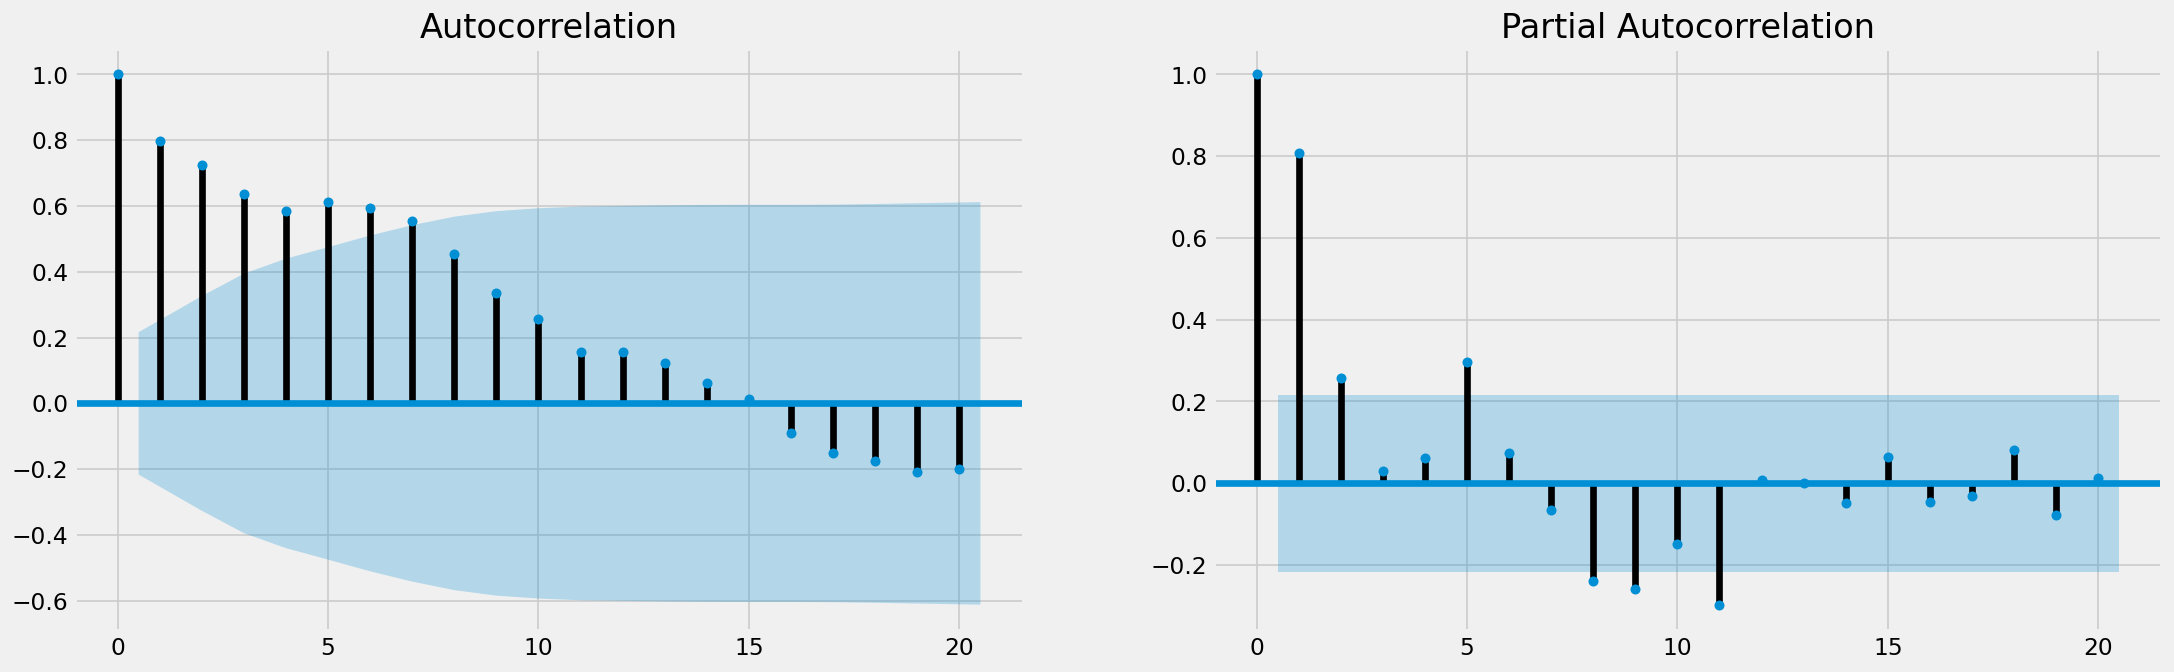

In [8]:
#Autocorrelation Mpil e Partial Autocorrelation
fig, axes = plt.subplots(1,2,figsize=(20,6), dpi= 120)
plot_acf(Mpil.new_cases.tolist(), lags=20, ax=axes[0])
plot_pacf(Mpil.new_cases.tolist(), lags=20, ax=axes[1])
plt.show()

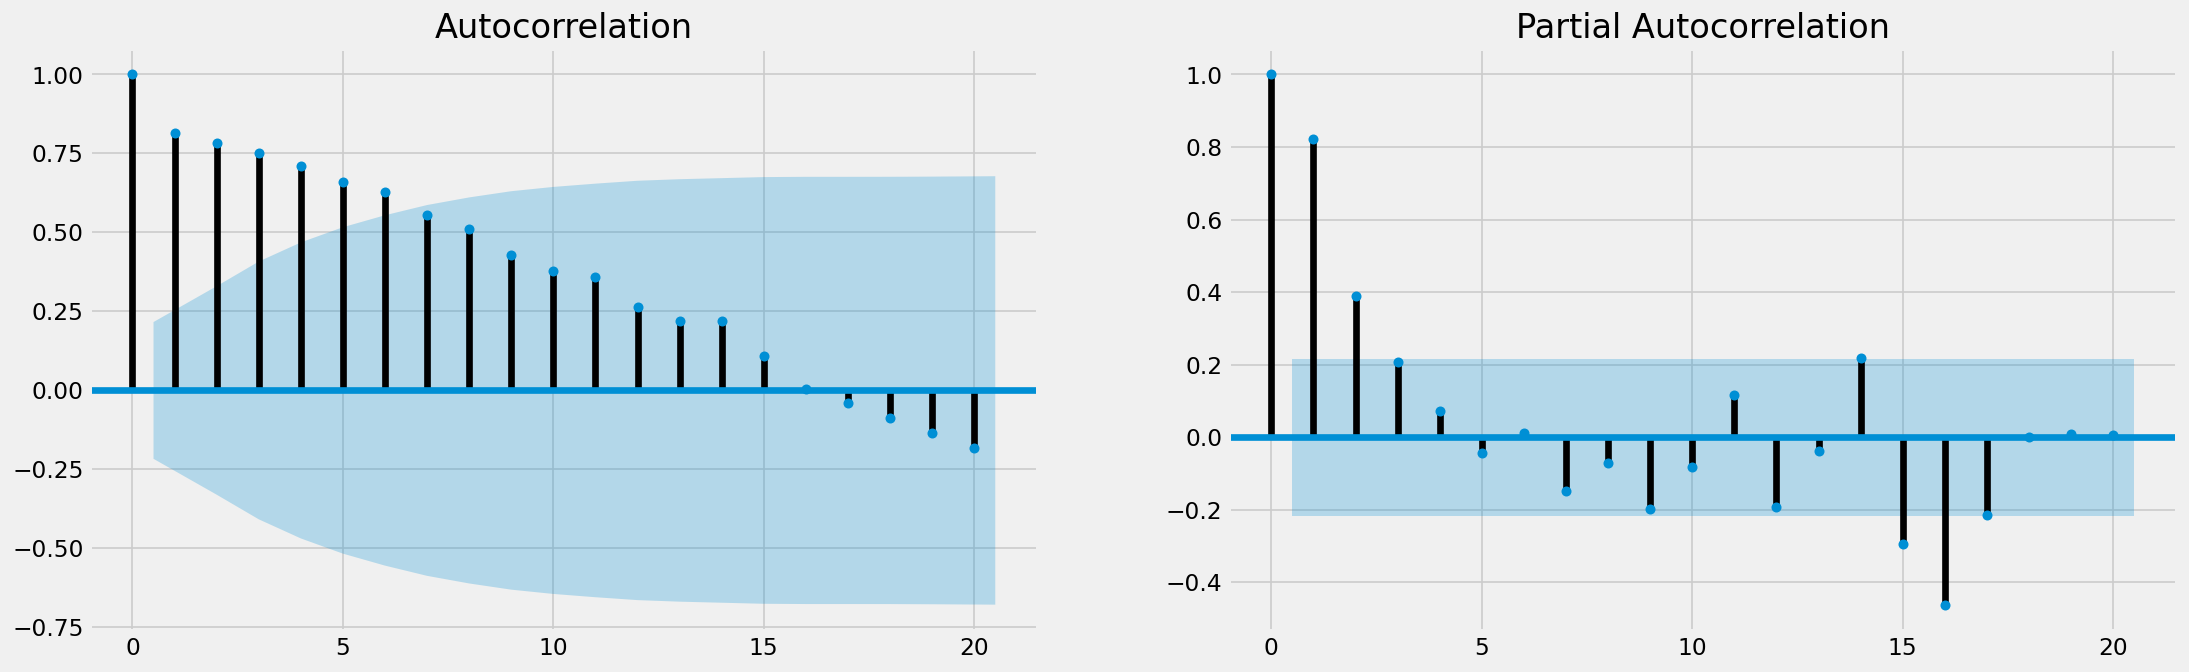

In [9]:
#Autocorrelation Mden e Partial Autocorrelation
fig, axes = plt.subplots(1,2,figsize=(20,6), dpi= 120)
plot_acf(Mden.new_cases.tolist(), lags=20, ax=axes[0])
plot_pacf(Mden.new_cases.tolist(), lags=20, ax=axes[1])
plt.show()

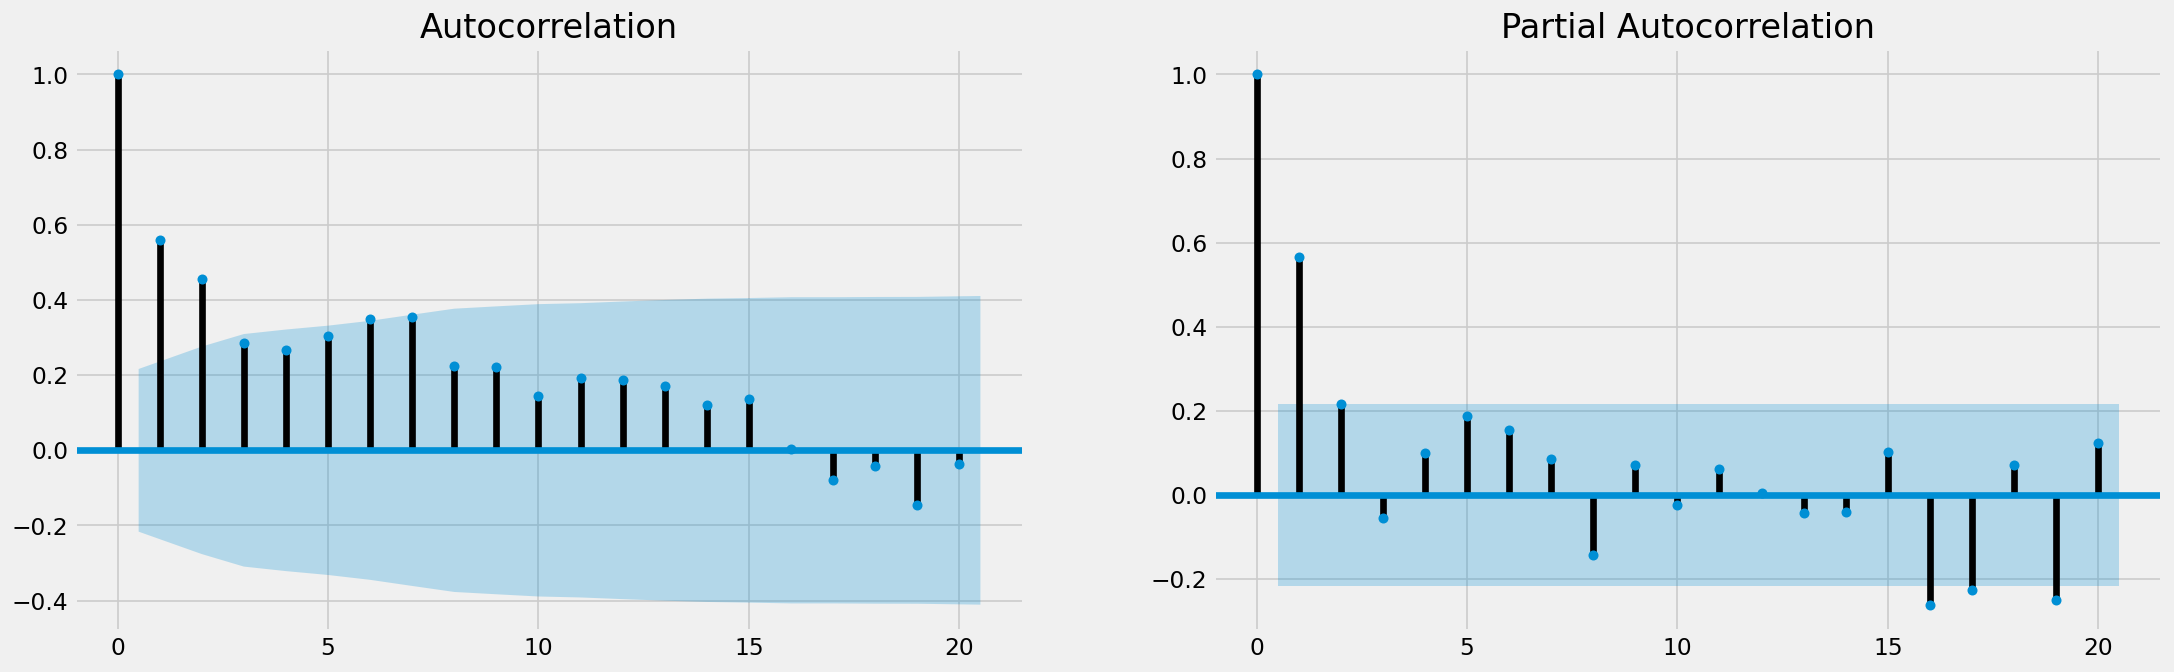

In [10]:
#Autocorrelation mtot e Partial Autocorrelation
fig, axes = plt.subplots(1,2,figsize=(20,6), dpi= 120)
plot_acf(mtot.new_cases.tolist(), lags=20, ax=axes[0])
plot_pacf(mtot.new_cases.tolist(), lags=20, ax=axes[1])
plt.show()

In [11]:
#divisione in train e test set per i 3 dataframe
train_MP = Mpil[:int(0.7*(len(Mpil)))]
test_MP = Mpil[int(0.7*(len(Mpil))):]

train_MD = Mden[:int(0.7*(len(Mden)))]
test_MD = Mden[int(0.7*(len(Mden))):]

train_mt = mtot[:int(0.7*(len(mtot)))]
test_mt = mtot[int(0.7*(len(mtot))):]

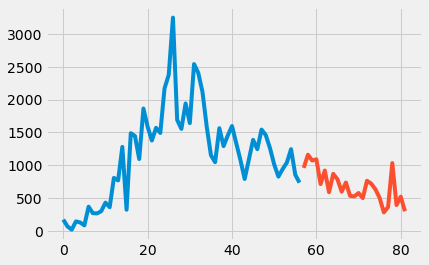

In [12]:
#Train e test per Mpil
train_MP['new_cases'].plot()
test_MP['new_cases'].plot()

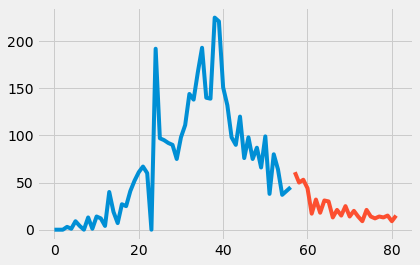

In [13]:
#Train e test per Mden
train_MD['new_cases'].plot()
test_MD['new_cases'].plot()

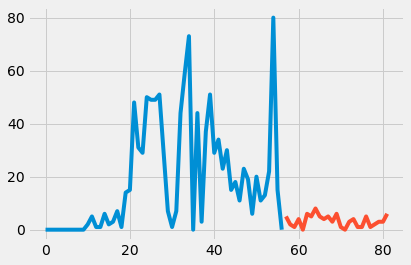

In [14]:
#Train e test per mtot
train_mt['new_cases'].plot()
test_mt['new_cases'].plot()

In [15]:
#Genero modello a partire da auto arima per regione con PIL più alto
model_MP = auto_arima(train_MP.new_cases,
                      start_p=1, start_q=1,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print("aic: ",model_MP.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=837.497, BIC=845.598, Time=0.082 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=842.204, BIC=846.255, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=838.142, BIC=844.218, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=836.371, BIC=842.447, Time=0.045 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=840.235, BIC=842.260, Time=0.005 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=837.672, BIC=845.774, Time=0.106 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=839.483, BIC=849.610, Time=0.122 seconds
Total fit time: 0.389 seconds
aic:  836.370836132793


In [16]:
#Genero modello a partire da auto arima per regione con densità più alta
model_MD = auto_arima(train_MD.new_cases,
                      start_p=1, start_q=1,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print("aic: ",model_MD.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=561.487, BIC=569.588, Time=0.055 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=573.294, BIC=577.345, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=563.109, BIC=569.185, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=559.751, BIC=565.827, Time=0.044 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=571.318, BIC=573.344, Time=0.005 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=561.397, BIC=569.498, Time=0.050 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=562.791, BIC=572.918, Time=0.133 seconds
Total fit time: 0.326 seconds
aic:  559.7512771732945


In [17]:
#Genero modello a partire da auto arima per regione con valori più bassi di PIL e densità
model_mt = auto_arima(train_mt.new_cases,
                      start_p=1, start_q=1,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print("aic: ",model_mt.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=490.870, BIC=498.972, Time=0.048 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=503.953, BIC=508.004, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=497.096, BIC=503.172, Time=0.022 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=491.126, BIC=497.202, Time=0.028 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=501.953, BIC=503.978, Time=0.005 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=492.729, BIC=502.855, Time=0.088 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=492.815, BIC=502.942, Time=0.077 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=491.346, BIC=499.448, Time=0.038 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=498.557, BIC=506.658, Time=0.032 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=494.292, BIC=506.444, Time=0.084 seconds
Total fit time: 0.438 seconds
aic:  490.8704095310861


In [18]:
#fit dei modelli sul train set

In [19]:
model_MP.fit(train_MP.new_cases)

ARIMA(order=(0, 1, 1), suppress_warnings=True)

In [20]:
model_MD.fit(train_MD.new_cases)

ARIMA(order=(0, 1, 1), suppress_warnings=True)

In [21]:
model_mt.fit(train_mt.new_cases)

ARIMA(order=(1, 1, 1), suppress_warnings=True)

In [22]:
#Plot dei grafici di diagnostica per i tre modelli

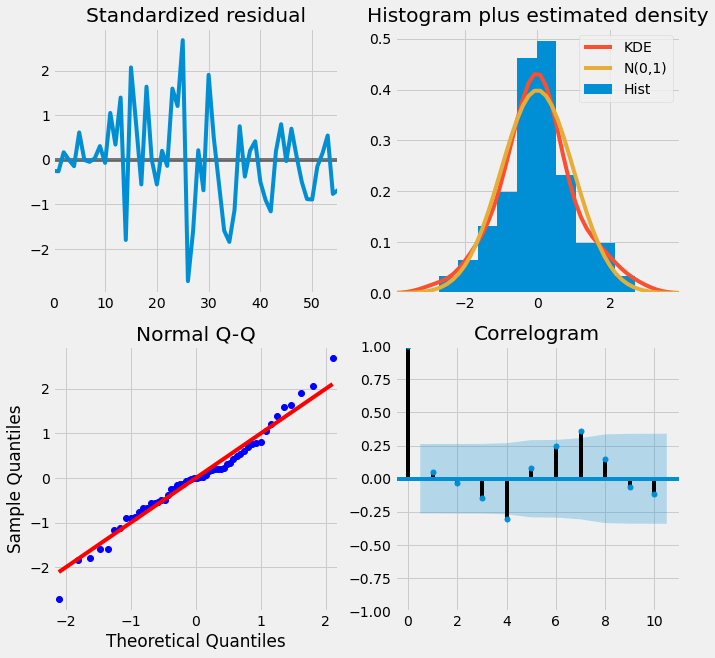

In [23]:
model_MP.plot_diagnostics(figsize=(10,10))
plt.show()

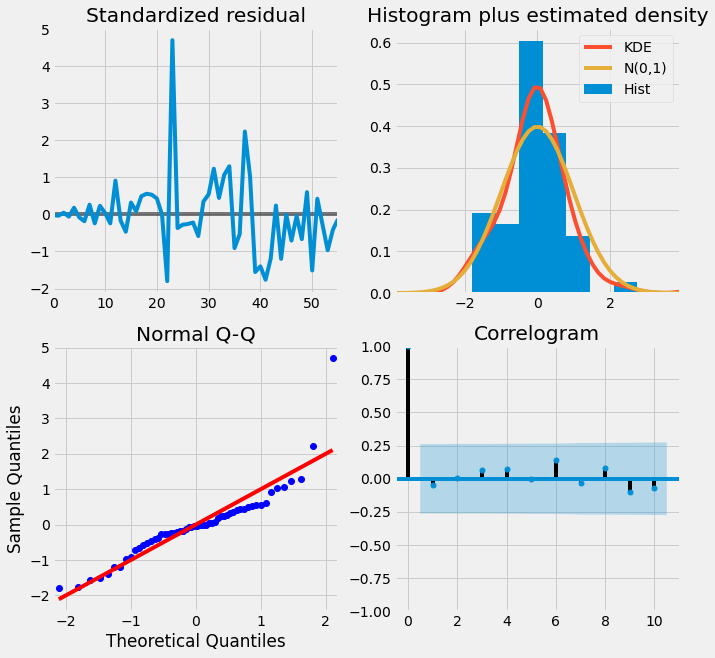

In [24]:
model_MD.plot_diagnostics(figsize=(10,10))
plt.show()

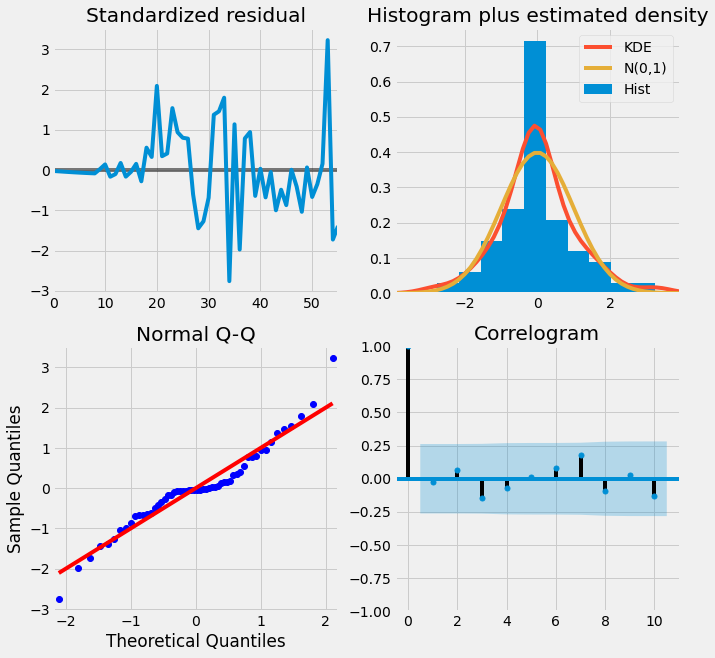

In [25]:
model_mt.plot_diagnostics(figsize=(10,10))
plt.show()

In [26]:
#Esecuzione della predizione sui modelli

In [27]:
forecast_MP= model_MP.predict(n_periods=len(test_MP))
forecast_MP = pd.DataFrame(forecast_MP,index = test_MP.index,columns=['Prediction'])

In [28]:
forecast_MD = model_MD.predict(n_periods=len(test_MD))
forecast_MD = pd.DataFrame(forecast_MD,index = test_MD.index,columns=['Prediction'])

In [29]:
forecast_mt = model_mt.predict(n_periods=len(test_mt))
forecast_mt = pd.DataFrame(forecast_mt,index = test_mt.index,columns=['Prediction'])

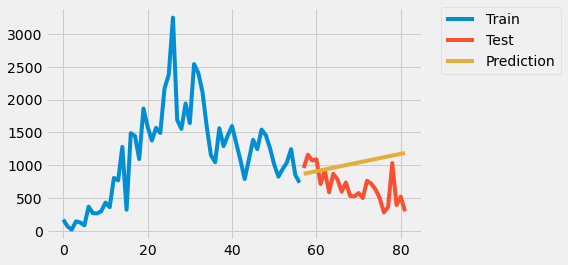

In [30]:
#plot predizioni per MP
plt.plot(train_MP.new_cases, label='Train')
plt.plot(test_MP.new_cases, label='Test')
plt.plot(forecast_MP, label='Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

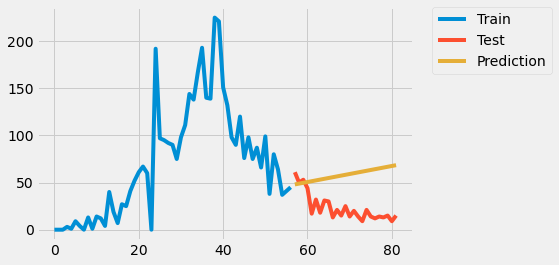

In [31]:
#plot predizioni per MD
plt.plot(train_MD.new_cases, label='Train')
plt.plot(test_MD.new_cases, label='Test')
plt.plot(forecast_MD, label='Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

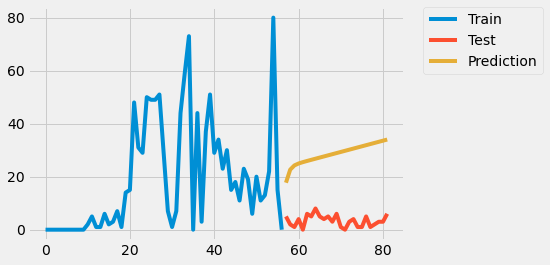

In [32]:
#plot predizioni per mt
plt.plot(train_mt.new_cases, label='Train')
plt.plot(test_mt.new_cases, label='Test')
plt.plot(forecast_mt, label='Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

Le predizioni generate con auto arima prevedono un incremento dei contagi (in tutte e tre le regioni) che non è avvenuto in quanto i contagi giornalieri si sono abbassati gradualmente con occasionali picchi di contagio (in Lombardia)

In [33]:
#calcolo rmse
rms_MP = sqrt(mean_squared_error(test_MP.new_cases,forecast_MP))
print("rmse Mpil: ",rms_MP)
rms_MD = sqrt(mean_squared_error(test_MD.new_cases,forecast_MD))
print("rmse Mden: ",rms_MD)
rms_mt = sqrt(mean_squared_error(test_MP.new_cases,forecast_MP))
print("rmse mtot: ",rms_mt)

rmse Mpil:  470.084720845815
rmse Mden:  40.02241552216155
rmse mtot:  470.084720845815


In [34]:
#SARMIAX

In [35]:
#Genero modello a partire da auto arima per regione con PIL più alto
smodel_MP = sm.tsa.statespace.SARIMAX(train_MP.new_cases,
                                order=(0,1,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                error_action='ignore',
                                suppress_warnings=True,)
sresults_MP = smodel_MP.fit()
print('AIC =', sresults_MP.aic) #AIC
#result_ARIMA = results.forecast(steps=test.shape[0])
sforecast_MP = sresults_MP.forecast(steps=test_MP.shape[0])

AIC = 465.5885033600658


In [36]:
#Genero modello a partire da auto arima per regione con densità più alta
smodel_MD = sm.tsa.statespace.SARIMAX(train_MD.new_cases,
                                order=(0,1,1),
                                seasonal_order=(1,0,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                error_action='ignore',
                                suppress_warnings=True,)
sresults_MD = smodel_MD.fit()
print('AIC =', sresults_MD.aic) #AIC
#result_ARIMA = results.forecast(steps=test.shape[0])
sforecast_MD = sresults_MD.forecast(steps=test_MD.shape[0])

AIC = 432.9257890316765


In [37]:
#Genero modello a partire da auto arima per regione con i valori più bassi per PIL e densità
smodel_mt = sm.tsa.statespace.SARIMAX(train_mt.new_cases,
                                order=(0,1,1),
                                seasonal_order=(1,0,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                error_action='ignore',
                                suppress_warnings=True,)
sresults_mt = smodel_mt.fit()
print('AIC =', sresults_mt.aic) #AIC
#result_ARIMA = results.forecast(steps=test.shape[0])
sforecast_mt = sresults_mt.forecast(steps=test_mt.shape[0])

AIC = 383.5538354699052


In [38]:
#converto in dataframe i risultati ottenuti
sresult_MP = pd.DataFrame()
sresult_MP['Actual'] = test_MP.new_cases
sresult_MP['Forecast'] = sforecast_MP.values.tolist()

sresult_MD = pd.DataFrame()
sresult_MD['Actual'] = test_MD.new_cases
sresult_MD['Forecast'] = sforecast_MD.values.tolist()

sresult_mt = pd.DataFrame()
sresult_mt['Actual'] = test_mt.new_cases
sresult_mt['Forecast'] = sforecast_mt.values.tolist()


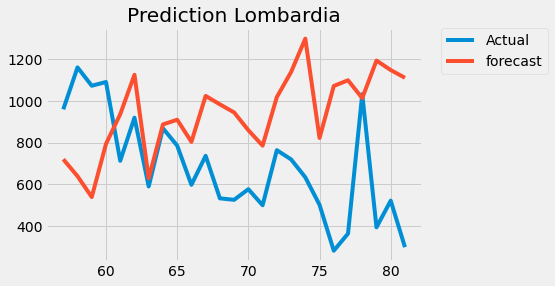

In [39]:
#predizione Lombardia contro valori attuali
plt.plot(sresult_MP.Actual, label="Actual")
plt.plot(sresult_MP.Forecast, label="forecast")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Prediction Lombardia")
plt.show()

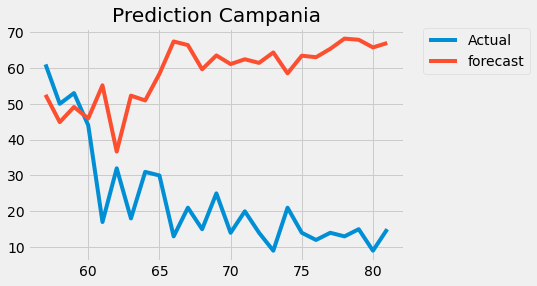

In [40]:
#predizione Campania contro valori attuali
plt.plot(sresult_MD.Actual, label="Actual")
plt.plot(sresult_MD.Forecast, label="forecast")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Prediction Campania")
plt.show()

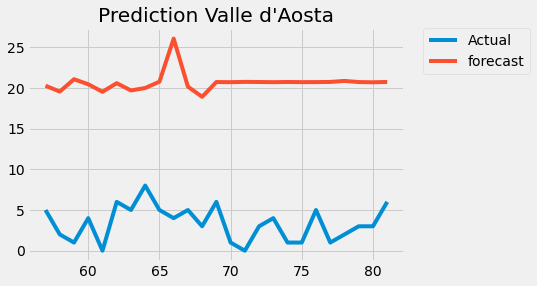

In [41]:
#predizione Valle d'Aosta contro valori attuali
plt.plot(sresult_mt.Actual, label="Actual")
plt.plot(sresult_mt.Forecast, label="forecast")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Prediction Valle d'Aosta")
plt.show()

Le predizioni effettuate usando sarima mostrano che ci sarà un aumento dei casi con picchi d'incremento (in Lombardia) ma i valori effettivi indicano che i contagi si sono abbassati nonostante alcuni picchi occasionali in Lombardia

In [42]:
#PROPHET

In [43]:
#imposto data come index per prophet
Mpil=Mpil.set_index('date')
Mden=Mden.set_index('date')
mtot=mtot.set_index('date')

In [44]:
#estraggo cronologia nuovi casi
nc_MP=Mpil.new_cases
nc_MD=Mden.new_cases
nc_mt=mtot.new_cases

In [45]:
#trasformo in dataframe
MP=pd.DataFrame(nc_MP)
MD=pd.DataFrame(nc_MD)
MT=pd.DataFrame(nc_mt)


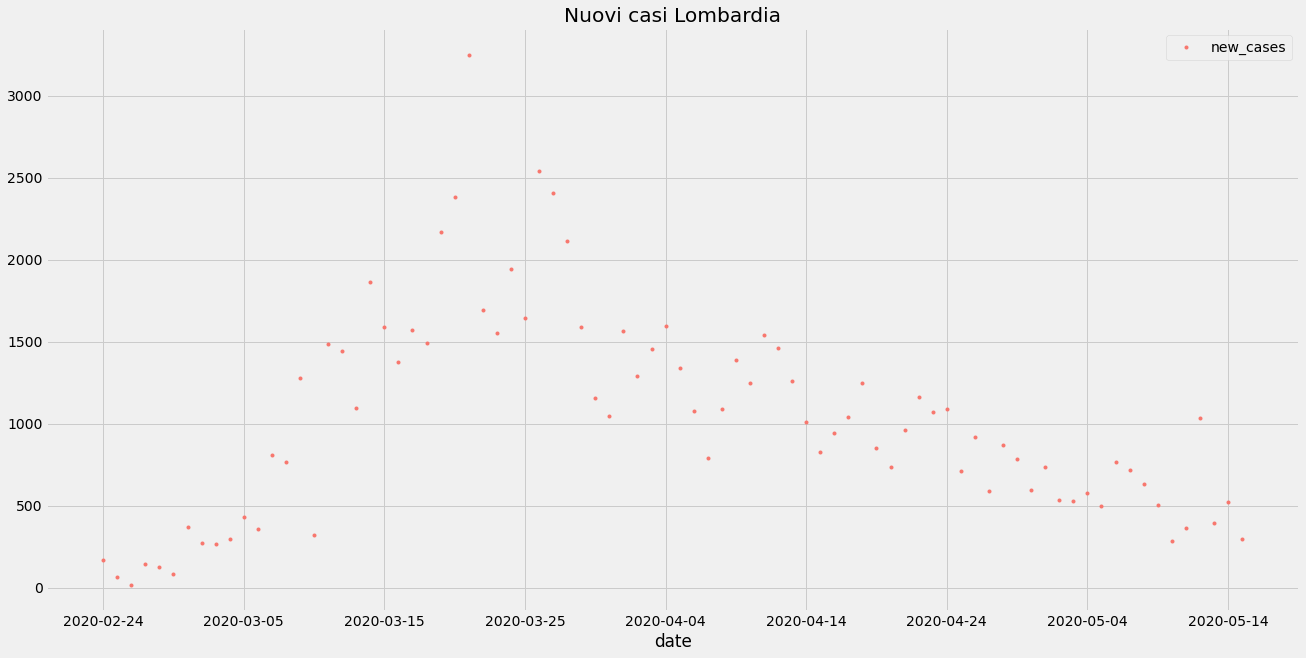

In [46]:
# Visualizzo dati
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
MP.plot(style='.', figsize=(20,10), color=color_pal[0], title='Nuovi casi Lombardia')
plt.show()

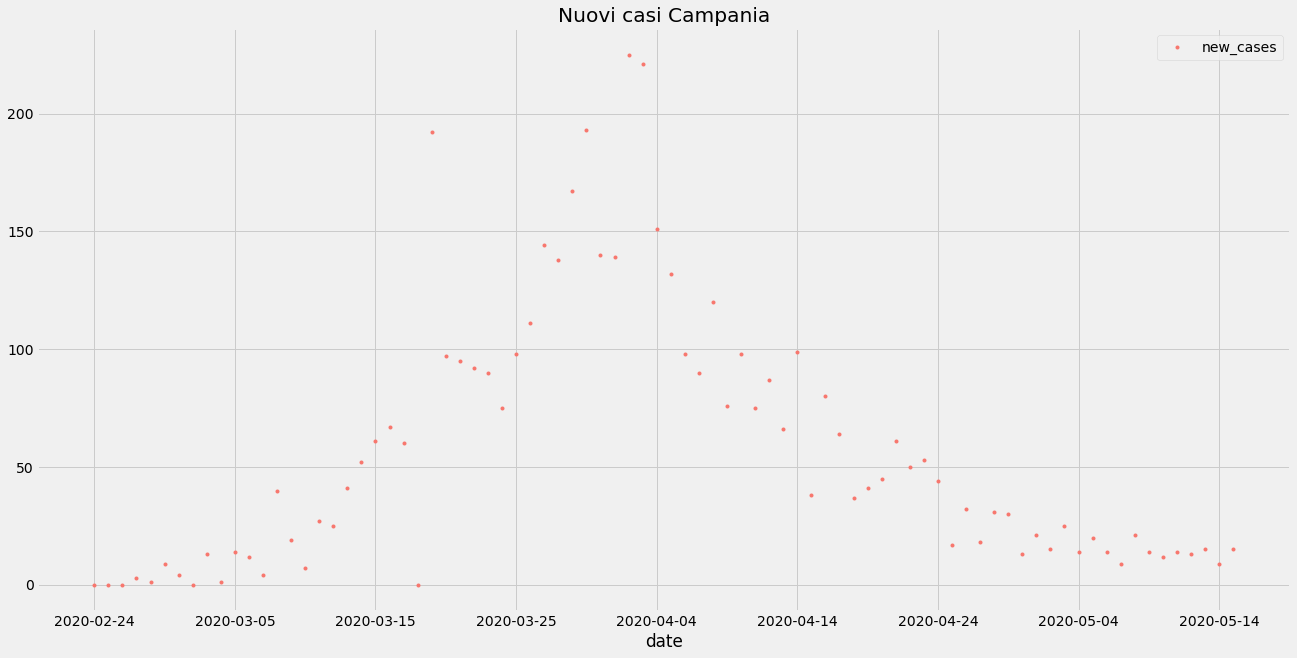

In [47]:
# Visualizzo dati
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
MD.plot(style='.', figsize=(20,10), color=color_pal[0], title='Nuovi casi Campania')
plt.show()

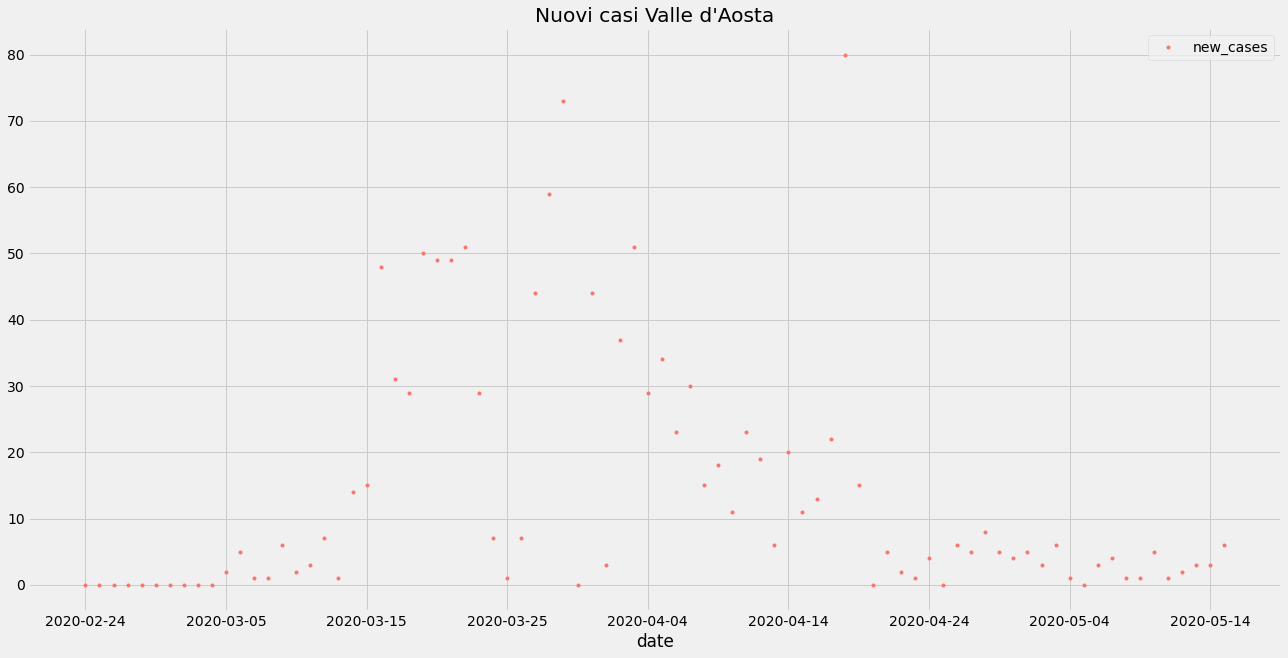

In [48]:
# Visualizzo dati
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
MT.plot(style='.', figsize=(20,10), color=color_pal[0], title="Nuovi casi Valle d'Aosta")
plt.show()

In [49]:
#Splitto in train e test
split_date = '2020-04-21'

MP_train = MP.loc[MP.index <= split_date].copy()
MP_test = MP.loc[MP.index > split_date].copy()

MD_train = MD.loc[MD.index <= split_date].copy()
MD_test = MD.loc[MD.index > split_date].copy()

MT_train = MT.loc[MT.index <= split_date].copy()
MT_test = MT.loc[MT.index > split_date].copy()

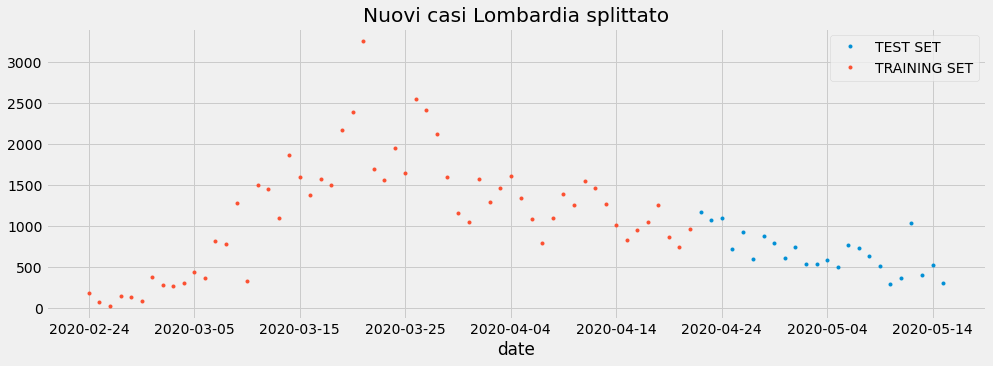

In [50]:
# Plot train e test MP
MP_test \
    .rename(columns={'new_cases': 'TEST SET'}) \
    .join(MP_train.rename(columns={'new_cases': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Nuovi casi Lombardia splittato', style='.')
plt.show()

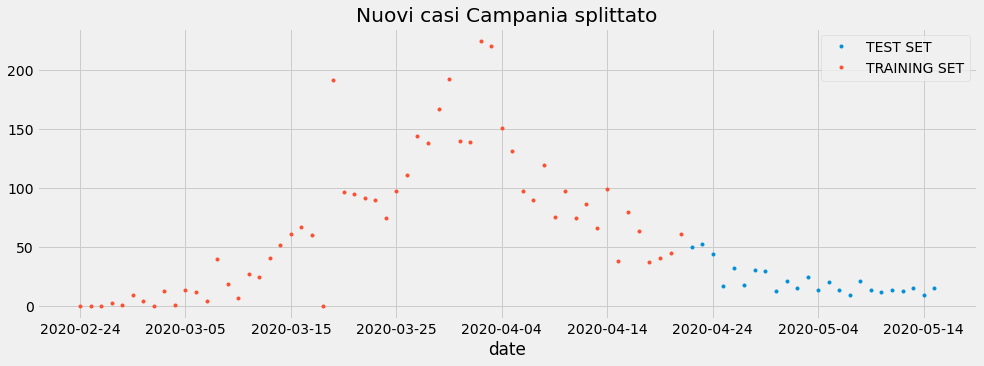

In [51]:
# Plot train e test MD
MD_test \
    .rename(columns={'new_cases': 'TEST SET'}) \
    .join(MD_train.rename(columns={'new_cases': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Nuovi casi Campania splittato', style='.')
plt.show()

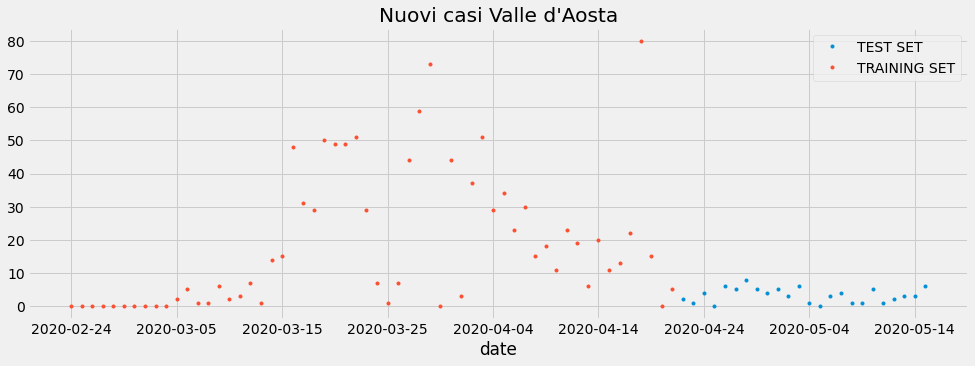

In [52]:
# Plot train e test MT
MT_test \
    .rename(columns={'new_cases': 'TEST SET'}) \
    .join(MT_train.rename(columns={'new_cases': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title="Nuovi casi Valle d'Aosta", style='.')
plt.show()

In [53]:
# Formatto dati per prophet con ds e y
MP_train.reset_index() \
    .rename(columns={'date':'ds',
                     'new_cases':'y'})

print(MP_train.columns)
MP_train.head(5)

Index(['new_cases'], dtype='object')


,new_cases
date,
2020-02-24,172
2020-02-25,68
2020-02-26,18
2020-02-27,145
2020-02-28,128


In [54]:
# Formatto dati per prophet con ds e y
MD_train.reset_index() \
    .rename(columns={'date':'ds',
                     'new_cases':'y'})

print(MD_train.columns)
MD_train.head(5)

Index(['new_cases'], dtype='object')


,new_cases
date,
2020-02-24,0
2020-02-25,0
2020-02-26,0
2020-02-27,3
2020-02-28,1


In [55]:
# Formatto dati per prophet con ds e y
MT_train.reset_index() \
    .rename(columns={'date':'ds',
                     'new_cases':'y'})

print(MT_train.columns)
MT_train.head(5)

Index(['new_cases'], dtype='object')


,new_cases
date,
2020-02-24,0
2020-02-25,0
2020-02-26,0
2020-02-27,0
2020-02-28,0


In [56]:
import timeit

In [57]:
#setup, train e fit MP
start_time=timeit.default_timer()

MPmodel = Prophet()
MPmodel.fit(MP_train.reset_index() \
              .rename(columns={'date':'ds',
                               'new_cases':'y'}))


elapsed=timeit.default_timer()-start_time
print("tempo: ",elapsed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


tempo:  1.6492382


In [58]:
#setup, train e fit MD
start_time=timeit.default_timer()

MDmodel = Prophet()
MDmodel.fit(MD_train.reset_index() \
              .rename(columns={'date':'ds',
                               'new_cases':'y'}))


elapsed=timeit.default_timer()-start_time
print("tempo: ",elapsed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


tempo:  0.7065083000000003


In [59]:
#setup, train e fit MT
start_time=timeit.default_timer()

MTmodel = Prophet()
MTmodel.fit(MT_train.reset_index() \
              .rename(columns={'date':'ds',
                               'new_cases':'y'}))


elapsed=timeit.default_timer()-start_time
print("tempo: ",elapsed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


tempo:  0.8410897999999998


In [60]:
# Predict sul training set con il modello MP
MP_test_fcst = MPmodel.predict(df=MP_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

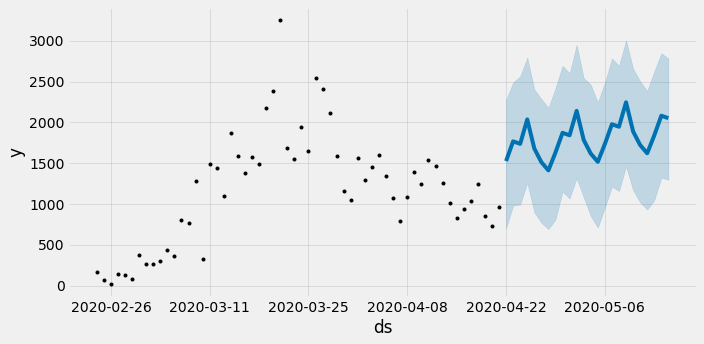

In [61]:
# plot forecast MP
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fig = MPmodel.plot(MP_test_fcst,
                 ax=ax)
plt.show()

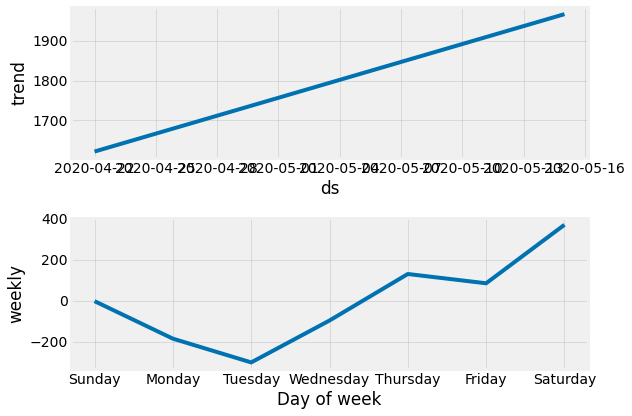

In [62]:
# Plot componenti MPmodel
fig = MPmodel.plot_components(MP_test_fcst)

In [63]:
# Predict sul training set con il modello MD
MD_test_fcst = MDmodel.predict(df=MD_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

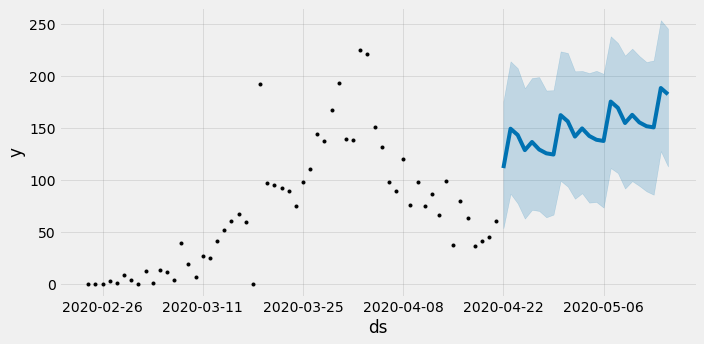

In [64]:
# plot forecast MD
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fig = MDmodel.plot(MD_test_fcst,
                 ax=ax)
plt.show()

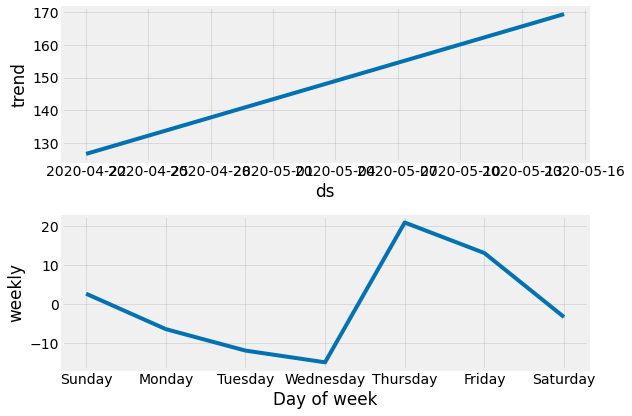

In [65]:
# Plot componenti MDmodel
fig = MDmodel.plot_components(MD_test_fcst)

In [66]:
# Predict sul training set con il modello MP
MT_test_fcst = MTmodel.predict(df=MT_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

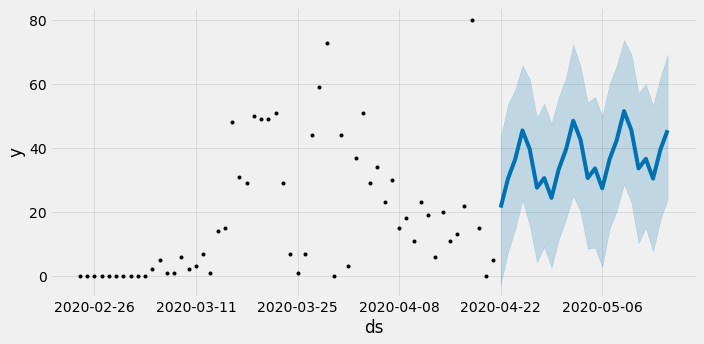

In [67]:
# plot forecast MT
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fig = MTmodel.plot(MT_test_fcst,
                 ax=ax)
plt.show()

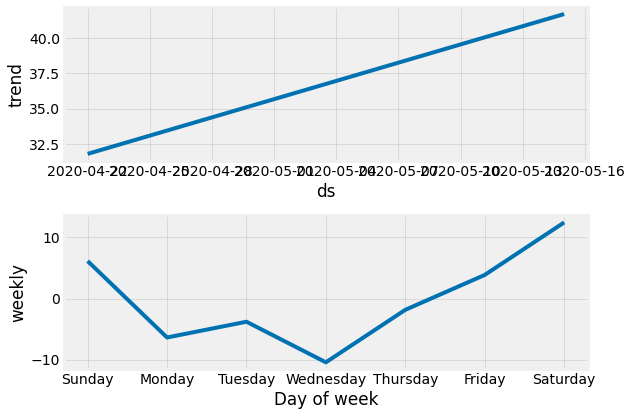

In [68]:
# Plot componenti MTmodel
fig = MTmodel.plot_components(MT_test_fcst)

Le previsioni per le tre regioni effettuate con prophet prevedono un andamento altanelante per tutte e tre le regioni con trend crescente per tutte e tre ma una componente settimanale diversa per ogni regione.

Per la Lombardia decrescetne fino a martedì per poi salire fino a giovedì, scendere leggermente a venerdì e poi risalire verso sabato.

Per la Campania l'andamento scende lentamente fino a mercoledì per salire velocemente a giovedì e infine scende di nuovo verso il sabato.

Per la Valle d'Aosta si ha una discesa da domenica fino a lunedì per poi salire leggermente il martedì e scendere di nuovo il mercoledì e infine si risale verso il sabato.